# Neural Style Transfer

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from PIL import Image

from os.path import join
import time

import torch
import torch.nn as nn
import torchvision
from torch import optim
from torchvision import transforms as tf
from torch.utils.data import DataLoader

from datasets import CachedDataset, MyDataset
from networks import AdaIN, EncoderVGG, Decoder
from loss import calculate_content_loss, calculate_style_loss

from utils import load_image, show_content_style_tradeoff_grid, show_style_and_content_img
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
torch.backends.cudnn.benchmark = True
# torch.set_num_threads(1)

In [3]:
content_img_path = 'C:/Users/Stefan/Desktop/Treca Godina/ORI/Image Captioning/ORI_ML/mscoco/train/img'
style_img_path = 'data/wikiart'

In [4]:
content_test_folder = 'images/input/content'
style_test_folder = 'images/input/style'
save_folder = 'saved_models/aws'

In [5]:
img_limit = 45000
cache_size = 11000
batch_size = 8 

## Define Transforms

In [6]:
transform = tf.Compose([
    tf.Resize(512),
    tf.RandomResizedCrop(256),
    tf.ToTensor()
])

In [7]:
test_transform = tf.Compose([
#     tf.Resize(1024),
    tf.ToTensor(), 
#     tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # normalize to Gaussian(0,1)
])

test_inverse = tf.Compose([
    tf.ToPILImage()
])

## Load data

In [8]:
content_dataset = MyDataset(content_img_path, transform, img_limit)
style_dataset = MyDataset(style_img_path, transform, img_limit)

In [9]:
len(content_dataset), len(style_dataset)

(45000, 45000)

In [10]:
content_loader = DataLoader(content_dataset, batch_size, num_workers=3, shuffle=True)
style_loader = DataLoader(style_dataset, batch_size, num_workers=3, shuffle=True)

## Initialize networks

In [11]:
torch.cuda.empty_cache()

encoder = EncoderVGG().to(device)
for net in encoder.subnets:
    net = net.to(device)

adain = AdaIN().to(device)
decoder = Decoder(encoder).to(device)

In [12]:
# decoder.load_state_dict(torch.load('saved_models/second_11000_25style.pt'))

<All keys matched successfully>

In [12]:
# decoder.load_state_dict(torch.load('saved_models/aws/test_45000imgs_min_loss_style25.pt'))

<All keys matched successfully>

## Hyperparameters

### Training Hyperparameters

In [13]:
num_epochs = 25
print_every = 1
show_result_every = 1
save_every = 3

### Algorithm hyperparameters

In [14]:
start_lr =  1e-4
end_lr = 1e-5
optimizer = optim.Adam(decoder.parameters(), lr=start_lr)
criterion = nn.MSELoss()
c_weight = 10
s_weight = 25

In [15]:
# Calculate lr_decay from start, end learning rate and number of epochs
lr_decay = (start_lr / end_lr - 1) / num_epochs

In [16]:
def adjust_learning_rate(optimizer, epoch, start_lr=start_lr, lr_decay=lr_decay):
    new_lr = calculate_new_lr(start_lr, lr_decay, epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
    return new_lr

def calculate_new_lr(start_lr, lr_decay, epoch):
    return start_lr / (1.0 + lr_decay * epoch)

### Visualize learning rate through epochs

In [17]:
def visualize_learning_rate():
    x = list(range(0, 1000))
    y = [calculate_new_lr(1e-4, 5e-3, i) for i in range(len(x))]
    
    plt.plot(x, y)
    print(f'Start learning rate {(y[0])} and End learning rate {y[-1]}')
 
 # visualize_learning_rate()

## Training

### Set fixed images to see algorithm improvement over time

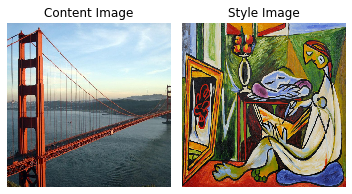

In [18]:
fixed_c_path = join(content_test_folder, 'golden_gate.jpg')
fixed_s_path = join(style_test_folder, 'la_muse.jpg')

fixed_c_img = test_transform(load_image(fixed_c_path)).to(device)
fixed_s_img = test_transform(load_image(fixed_s_path)).to(device)

show_style_and_content_img(fixed_c_img, fixed_s_img, test_inverse, figsize=(5,10))

In [19]:
def test(c_img, s_img, alpha=1., clamp=True):
    torch.cuda.empty_cache()
    encoder.eval()
    decoder.eval()
    
    c_img = c_img.unsqueeze(0)
    s_img = s_img.unsqueeze(0)

    encoded_style_test = encoder(s_img)
    encoded_content_test = encoder(c_img)[-1]

    adain_out_test = adain(encoded_content_test, encoded_style_test[-1], alpha)

    out_img = decoder(adain_out_test).cpu().squeeze(0)
    if clamp:
        out_img = torch.clamp(out_img, -1, 1)
    return test_inverse(out_img)

### Single training step

In [20]:
def train_step(content_batch, style_batch):
    optimizer.zero_grad()
    
    encoded_style = encoder(style_batch)
    encoded_content = encoder(content_batch)[-1]
    
    adain_out = adain(encoded_content, encoded_style[-1])
    
    out_img_batch = decoder(adain_out)
    
    encoded_out_batch = encoder(out_img_batch)
    
    content_loss = calculate_content_loss(encoded_out_batch[-1], adain_out, criterion)
    style_loss = calculate_style_loss(encoded_out_batch, encoded_style, criterion)
    loss = s_weight * style_loss + c_weight * content_loss
    loss.backward()
    optimizer.step()
    return loss

In [22]:
min_loss = float('Inf')
min_loss_save_cutoff = 0

### Training loop

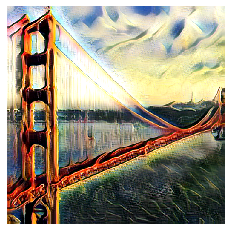

Epoch 0 Loss 31.1060 Learning Rate 1.000e-04 Min Loss 31.11
Time taken for epoch 2259 sec



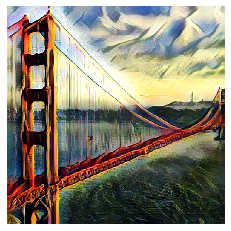

Epoch 1 Loss 28.0926 Learning Rate 7.353e-05 Min Loss 28.09
Time taken for epoch 2252 sec



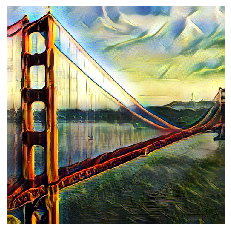

Epoch 2 Loss 25.3720 Learning Rate 5.814e-05 Min Loss 25.37
Time taken for epoch 2250 sec



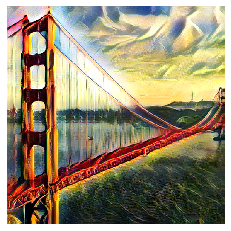

Epoch 3 Loss 23.9068 Learning Rate 4.808e-05 Min Loss 23.91
Time taken for epoch 2250 sec



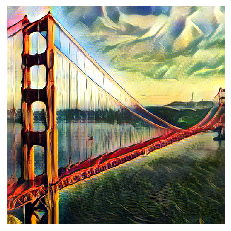

Epoch 4 Loss 22.8079 Learning Rate 4.098e-05 Min Loss 22.81
Time taken for epoch 2251 sec



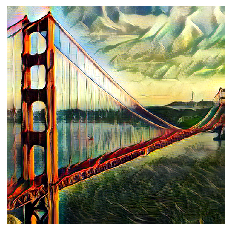

Epoch 5 Loss 21.9530 Learning Rate 3.571e-05 Min Loss 21.95
Time taken for epoch 2250 sec



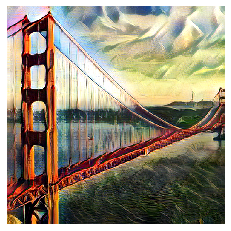

Epoch 6 Loss 21.4085 Learning Rate 3.165e-05 Min Loss 21.41
Time taken for epoch 2249 sec



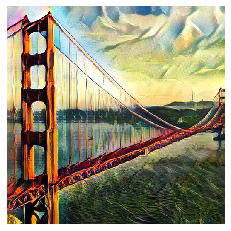

Epoch 7 Loss 21.0293 Learning Rate 2.841e-05 Min Loss 21.03
Time taken for epoch 2248 sec



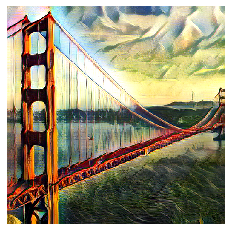

Epoch 8 Loss 20.6600 Learning Rate 2.577e-05 Min Loss 20.66
Time taken for epoch 2250 sec



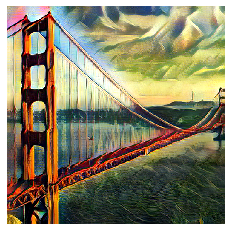

Epoch 9 Loss 20.3132 Learning Rate 2.358e-05 Min Loss 20.31
Time taken for epoch 2250 sec



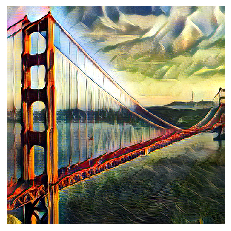

Epoch 10 Loss 20.1585 Learning Rate 2.174e-05 Min Loss 20.16
Time taken for epoch 2250 sec



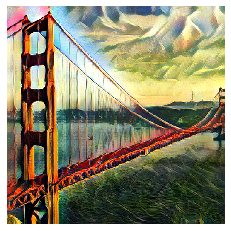

Epoch 11 Loss 19.8222 Learning Rate 2.016e-05 Min Loss 19.82
Time taken for epoch 2250 sec



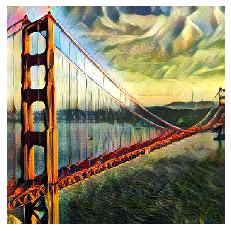

Epoch 12 Loss 19.6482 Learning Rate 1.880e-05 Min Loss 19.65
Time taken for epoch 2250 sec



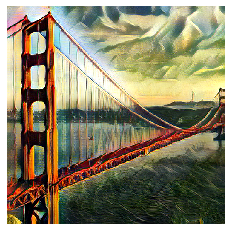

Epoch 13 Loss 19.4860 Learning Rate 1.761e-05 Min Loss 19.49
Time taken for epoch 2250 sec



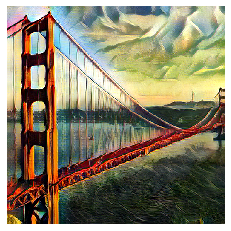

Epoch 14 Loss 19.3126 Learning Rate 1.656e-05 Min Loss 19.31
Time taken for epoch 2301 sec



KeyboardInterrupt: 

In [22]:
def train(start_epoch=0):
    global min_loss
    
    decoder.train()
    encoder.train()
    
    for epoch in range(start_epoch, num_epochs):
        start = time.time()
        total_loss = 0
        steps = 0
        for content_batch, style_batch in zip(content_loader, style_loader):
            content_batch, style_batch = content_batch.to(device), style_batch.to(device)
            total_loss += train_step(content_batch, style_batch).detach().item()
            steps += 1
        
        avg_batch_loss = total_loss / steps
        
        new_lr = adjust_learning_rate(optimizer, epoch)
        
        if epoch % show_result_every == 0:
            plt.axis('off')
            plt.imshow(test(fixed_c_img, fixed_s_img))
            plt.show()
        
        if avg_batch_loss < min_loss:
            min_loss = avg_batch_loss
            if epoch >= min_loss_save_cutoff:
                torch.save(decoder.state_dict(), f'{save_folder}/test_{img_limit}imgs_min_loss_style{s_weight}.pt')
        if epoch and epoch % save_every == 0:
            torch.save(decoder.state_dict(), f'{save_folder}/test_{img_limit}imgs_loss_{avg_batch_loss:.{2}f}_style{s_weight}_epoch{epoch}.pt')
        
        if epoch % print_every == 0:
            print(f'Epoch {epoch} Loss {avg_batch_loss:.{4}f} Learning Rate {new_lr:.3e} Min Loss {min_loss:.{2}f}')
            print(f'Time taken for epoch {(time.time() - start):.{0}f} sec\n')

train()    

In [ ]:
# torch.save(decoder.state_dict(), 'saved_models/third_25000_25style.pt')

## Testing

In [23]:
content_img = fixed_c_img
style_img = fixed_s_img

In [23]:
style_dataset.img_names[1824]

'102166.jpg'

In [ ]:
from random import randrange
idx = randrange(img_limit)
print(style_dataset.img_names[idx])
style_img = style_dataset.get_no_transform(idx).to(device)
test_inverse(style_img.cpu())

In [34]:
style_img = test_transform(load_image(join(style_test_folder, '18299.jpg'))).to(device)

In [31]:
style_img = test_transform(load_image(join(style_test_folder, 'asheville.jpg'))).to(device)

In [28]:
style_img = test_transform(load_image(join(style_test_folder, '101862.jpg'))).to(device)

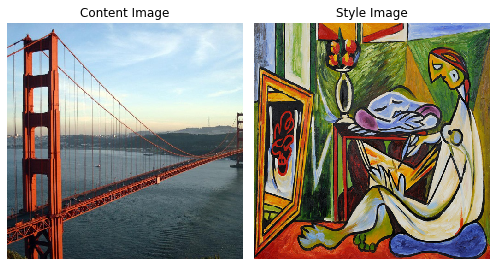

In [24]:
show_style_and_content_img(content_img, style_img, test_inverse)

In [ ]:
test(content_img, style_img)   # 1 style

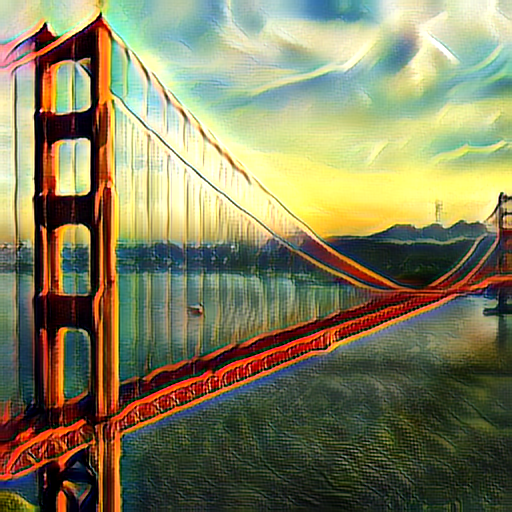

In [27]:
test(content_img, style_img)   # 1 style

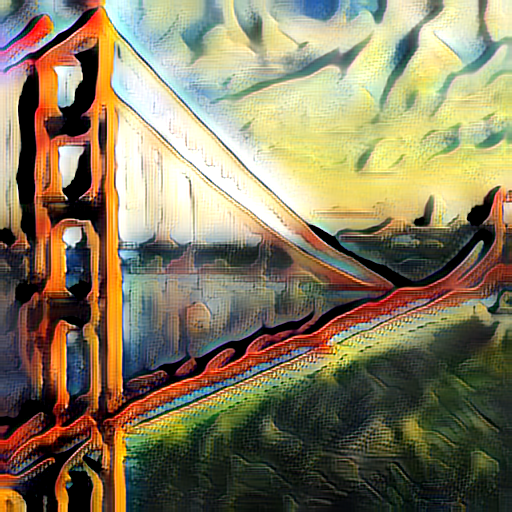

In [40]:
test(content_img, style_img)   # 25 style (11 000 model)

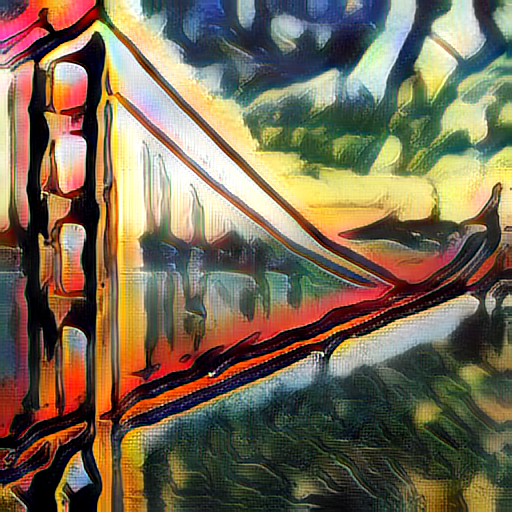

In [28]:
test(content_img, style_img)  #22 loss, 50style

In [ ]:
show_content_style_tradeoff_grid(content_img, style_img, test, test_inverse)

In [ ]:
show_content_style_tradeoff_grid(content_img, fixed_s_img, test, test_inverse)

In [ ]:
test(fixed_c_img, fixed_s_img) # 25 25000

In [ ]:
test(fixed_c_img, fixed_s_img) # 25 11000

In [ ]:
test(fixed_c_img, fixed_s_img) # 100

In [ ]:
test(fixed_c_img, fixed_s_img) # 25

In [ ]:
test(fixed_c_img, fixed_s_img) # 50